In [86]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import History 
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import pandas_datareader.data as web
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols

### Reading in the data

In [2]:
df = pd.read_csv('dataframe.csv')

In [3]:
df.columns

Index(['date', 'LOW_x', 'HIGH_x', 'PRICE_x', 'CLOSINGBID_x', 'CLOSEINGASK_x',
       'VOL_x', 'LOW_y', 'HIGH_y', 'PRICE_y', 'CLOSINGBID_y', 'CLOSEINGASK_y',
       'VOL_y', 'dailyreturns', 'totalcap', 'chngcap', 'divfac', 'spread',
       'shrout', 'SDT_RET', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF',
       'SPYRET', 'TMW_SPYRET', 'UP_DWN', 'X5', 'X10', 'X15', 'X20', 'X25',
       'X30', 'X35', 'X40', 'X45', 'X50', 'X55', 'X60', 'X65', 'X70', 'X75',
       'X80', 'X85', 'X90', 'X95', 'SINTMWSPYRET'],
      dtype='object')

In [4]:
df

,date,LOW_x,HIGH_x,PRICE_x,CLOSINGBID_x,CLOSEINGASK_x,VOL_x,LOW_y,HIGH_y,PRICE_y,...,X55,X60,X65,X70,X75,X80,X85,X90,X95,SINTMWSPYRET
0,1993-02-02,44.12500,44.37500,44.34375,44.31250,44.34375,201300.0,44.12500,44.37500,44.34375,...,0.003362,0.005391,0.008108,0.009342,0.011046,0.012827,0.014375,0.018218,0.021659,0.870934
1,1993-02-03,44.37500,44.84375,44.81250,44.81250,44.84375,529400.0,44.37500,44.84375,44.81250,...,0.011098,0.012585,0.013621,0.015758,0.018100,0.020447,0.021907,0.027264,0.040422,0.406299
2,1993-02-04,44.87500,45.09375,45.00000,44.96875,45.00000,531500.0,44.87500,45.09375,45.00000,...,0.007182,0.009021,0.010642,0.012585,0.014750,0.018742,0.021051,0.025016,0.032828,-0.069344
3,1993-02-05,44.71875,45.06250,44.96875,44.96875,45.00000,492100.0,44.71875,45.06250,44.96875,...,0.000000,0.002073,0.003073,0.005113,0.008612,0.010919,0.013699,0.015543,0.026057,0.000000
4,1993-02-08,44.90625,45.12500,44.96875,44.84375,44.87500,596100.0,44.90625,45.12500,44.96875,...,-0.003113,-0.002140,0.000000,0.000000,0.003278,0.004249,0.010087,0.014019,0.017157,-0.640309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7008,2020-12-24,367.45001,369.03000,369.00000,368.97000,368.98999,26457853.0,367.45001,369.03000,369.00000,...,0.003819,0.004234,0.004842,0.006083,0.006912,0.007937,0.010267,0.011410,0.016761,0.757255
7009,2020-12-28,371.07001,372.59000,372.17001,372.13000,372.14001,39000402.0,371.07001,372.59000,372.17001,...,0.005807,0.006430,0.007072,0.008633,0.009715,0.011287,0.013402,0.017880,0.023810,-0.189644
7010,2020-12-29,370.82999,374.00000,371.45999,371.47000,371.47000,53680451.0,370.82999,374.00000,371.45999,...,0.000024,0.001805,0.003594,0.004519,0.005253,0.006338,0.007910,0.011631,0.020131,0.142216
7011,2020-12-30,371.57001,373.10001,371.98999,371.92001,371.92999,49455259.0,371.57001,373.10001,371.98999,...,0.001542,0.002260,0.002947,0.005485,0.007773,0.009025,0.011140,0.015764,0.021914,0.486518


### We only look at the dates from 2011 to end of 2021

In [5]:
df1 = df[df['date']>= '2010-12-31']

In [6]:
df1 = df1.reset_index(drop=True)

In [7]:
train_size = round(0.7*len(df1))

### Only pulling the variabels that we want

In [8]:
training_set = df1.iloc[:train_size, [1,2,3,6,11,15]].values
test_set =df1.iloc[train_size:, [1,2,3,6,11,15]].values

### Scaling the data to be between 0 and 1

In [72]:
sc = MinMaxScaler(feature_range = (0, 1))
x_training_set_scaled = sc.fit_transform(training_set[:,[0,1,3,4,5]])
y_training_set_scaled = sc.fit_transform(training_set[:,2:3])

### This creates a function that will loop through 30 rolling days to predict the thirty first day this will be our prediction function

In [73]:
X_train = []
y_train = []
for i in range(30, train_size):
    X_train.append(x_training_set_scaled[i-30:i,:])
    y_train.append(y_training_set_scaled[i,:])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))

### this does the same as above but for the testing data

In [79]:
x_test_set_scaled = sc.fit_transform(test_set[:,[0,1,3,4,5]])
y_test_set_scaled = sc.fit_transform(test_set[:,2:3])
X_test = []
y_test = []
for i in range(30, (len(df1) - train_size)):
    X_test.append(x_test_set_scaled[i-30:i,:])
    y_test.append(y_test_set_scaled[i,:])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

### Creating and training 4 LSTM layers.

In [43]:
def lstm(x_train,y_train,x_test,y_test,epochs):
    history = History()
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 5)))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    model.fit(x_train, y_train, epochs = epochs, batch_size = 20,callbacks=[history])
    
    predicted_stock_price = model.predict(x_test)
    
    mse = mean_squared_error(y_test,predicted_stock_price)
    loss = history.history['loss']
    
    #return mse
    return loss

### This will loop through all of the possible numbe rof Epochs in steps of 5 up to a total of 50 epochs

In [38]:
test_mse = []
for i in range(5,55,5):
    
    test_mse.append(lstm(X_train,y_train,X_test,y_test,i))

Epoch 1/5
87/87 [==============================] - 6s 24ms/step - loss: 0.0141
Epoch 2/5
87/87 [==============================] - 2s 24ms/step - loss: 0.0040
Epoch 3/5
87/87 [==============================] - 2s 24ms/step - loss: 0.0035
Epoch 4/5
87/87 [==============================] - 2s 24ms/step - loss: 0.0030
Epoch 5/5
87/87 [==============================] - 2s 24ms/step - loss: 0.0031
Epoch 1/10
87/87 [==============================] - 6s 26ms/step - loss: 0.0134
Epoch 2/10
87/87 [==============================] - 2s 27ms/step - loss: 0.0035
Epoch 3/10
87/87 [==============================] - 2s 27ms/step - loss: 0.0033
Epoch 4/10
87/87 [==============================] - 2s 27ms/step - loss: 0.0035
Epoch 5/10
87/87 [==============================] - 2s 27ms/step - loss: 0.0027
Epoch 6/10
87/87 [==============================] - 2s 27ms/step - loss: 0.0025
Epoch 7/10
87/87 [==============================] - 2s 27ms/step - loss: 0.0024
Epoch 8/10
87/87 [===========================

87/87 [==============================] - 2s 27ms/step - loss: 0.0014
Epoch 28/30
87/87 [==============================] - 2s 27ms/step - loss: 0.0014
Epoch 29/30
87/87 [==============================] - 2s 27ms/step - loss: 0.0013
Epoch 30/30
87/87 [==============================] - 2s 27ms/step - loss: 0.0013
Epoch 1/35
87/87 [==============================] - 6s 28ms/step - loss: 0.0162
Epoch 2/35
87/87 [==============================] - 2s 28ms/step - loss: 0.0037
Epoch 3/35
87/87 [==============================] - 2s 28ms/step - loss: 0.0036
Epoch 4/35
87/87 [==============================] - 2s 28ms/step - loss: 0.0032
Epoch 5/35
87/87 [==============================] - 2s 28ms/step - loss: 0.0030
Epoch 6/35
87/87 [==============================] - 2s 28ms/step - loss: 0.0025
Epoch 7/35
87/87 [==============================] - 2s 28ms/step - loss: 0.0024
Epoch 8/35
87/87 [==============================] - 2s 28ms/step - loss: 0.0024
Epoch 9/35
87/87 [==============================

87/87 [==============================] - 3s 29ms/step - loss: 0.0015
Epoch 24/45
87/87 [==============================] - 3s 29ms/step - loss: 0.0016
Epoch 25/45
87/87 [==============================] - 3s 29ms/step - loss: 0.0016
Epoch 26/45
87/87 [==============================] - 3s 29ms/step - loss: 0.0015
Epoch 27/45
87/87 [==============================] - 3s 29ms/step - loss: 0.0014
Epoch 28/45
87/87 [==============================] - 2s 29ms/step - loss: 0.0015
Epoch 29/45
87/87 [==============================] - 2s 29ms/step - loss: 0.0016
Epoch 30/45
87/87 [==============================] - 2s 29ms/step - loss: 0.0015
Epoch 31/45
87/87 [==============================] - 2s 29ms/step - loss: 0.0013
Epoch 32/45
87/87 [==============================] - 2s 29ms/step - loss: 0.0014
Epoch 33/45
87/87 [==============================] - 2s 29ms/step - loss: 0.0014
Epoch 34/45
87/87 [==============================] - 2s 29ms/step - loss: 0.0012
Epoch 35/45
87/87 [=====================

### Looking at this as a result of the 50 epochs which was found to be best

In [44]:
train_mse = lstm(X_train,y_train,X_test,y_test,50)

Epoch 1/50
87/87 [==============================] - 7s 31ms/step - loss: 0.0167
Epoch 2/50
87/87 [==============================] - 3s 29ms/step - loss: 0.0037
Epoch 3/50
87/87 [==============================] - 3s 29ms/step - loss: 0.0032
Epoch 4/50
87/87 [==============================] - 3s 29ms/step - loss: 0.0031
Epoch 5/50
87/87 [==============================] - 3s 29ms/step - loss: 0.0029
Epoch 6/50
87/87 [==============================] - 3s 29ms/step - loss: 0.0030
Epoch 7/50
87/87 [==============================] - 3s 29ms/step - loss: 0.0027
Epoch 8/50
87/87 [==============================] - 3s 29ms/step - loss: 0.0026
Epoch 9/50
87/87 [==============================] - 3s 29ms/step - loss: 0.0024
Epoch 10/50
87/87 [==============================] - 3s 29ms/step - loss: 0.0029
Epoch 11/50
87/87 [==============================] - 3s 29ms/step - loss: 0.0026
Epoch 12/50
87/87 [==============================] - 3s 29ms/step - loss: 0.0022
Epoch 13/50
87/87 [==================

In [47]:
train_loss = []
for i in range(5,55,5):
    train_loss.append(train_mse[i-1])

In [50]:
epochs = np.arange(5,55,5)

### Plotting how the accuracies change over time with epochs. Both the train and test

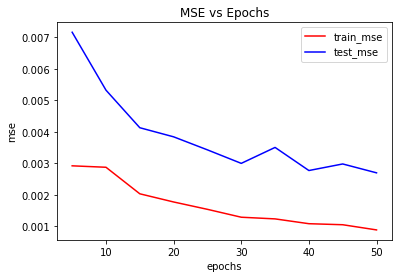

In [54]:
plt.plot(epochs,train_loss,color = 'red', label = 'train_mse')
plt.plot(epochs,test_mse,color = 'blue', label = 'test_mse')
plt.title('MSE vs Epochs')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

In [103]:
predicted_stock_price = model.predict(X_test)

### Both of these cells convert the functions back to the pre scaled functions

In [ ]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
y_test = sc.inverse_transform(y_test)

### Plotting the outcome of the predictions vs the actuals

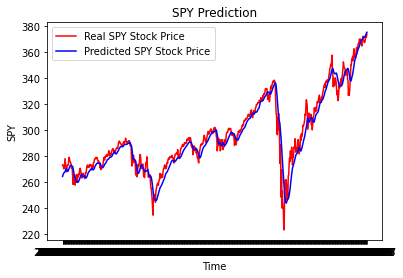

In [117]:
# Visualising the results
plt.plot(df1.loc[train_size:len(df1)-31, 'date'],y_test, color = 'red', label = 'Real SPY Stock Price')
plt.plot(df1.loc[train_size:len(df1)-31, 'date'],predicted_stock_price, color = 'blue', label = 'Predicted SPY Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('SPY Prediction')
plt.xlabel('Time')
plt.ylabel('SPY')
plt.legend()
plt.show()

In [110]:
regression = pd.DataFrame(y_test)
regression['predict'] = predicted_stock_price

In [112]:
regression.columns = ['real','predict']

### We run this regression to check and see how the model works in explaining the actual stock price

In [113]:
regression

,real,predict
0,273.03000,264.149200
1,273.10999,265.367493
2,271.39999,266.144714
3,270.04999,266.695618
4,270.39999,267.112183
...,...,...
720,369.00000,372.075043
721,372.17001,372.954742
722,371.45999,373.970245
723,371.98999,374.782379


In [115]:
model = ols('predict ~ real',regression).fit()

In [116]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                predict   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Sat, 04 Dec 2021   Prob (F-statistic):               0.00
Time:                        23:45:26   Log-Likelihood:                -2459.6
No. Observations:                 725   AIC:                             4923.
Df Residuals:                     723   BIC:                             4932.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1071      2.751      1.856      0.064      -0.295      10.509
real           0.9760      0.009    105.663      0.000       0.958       0.994
==============================================================================
Omnibus:                      284.794   Durbin-Watson:                   0.324
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2005.637
Skew:                           1.596   Prob(JB):                         0.00
Kurtosis:                      10.497   Cond. No.                     3.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""